In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -uq "/content/drive/MyDrive/DL_HW3_Q2/SemEval2010_task8_all_data.zip" -d "/content" 

In [3]:
!unzip -uq '/content/drive/MyDrive/DL_HW3_Q2/glove.42B.300d.zip' -d "/content" 

In [4]:
import nltk
tokenizer=nltk.RegexpTokenizer(r"\w+")
from sklearn.model_selection import train_test_split

import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
import spacy
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import nltk

torch.manual_seed(17)
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.optim import Adam, SGD
from math import floor
from torch.utils.data import Dataset
from __future__ import division
import math
from PIL import Image, ImageOps
try:
    import accimage
except ImportError:
    accimage = None
import numbers
import types
import collections
from torchvision import transforms
from scipy.ndimage import gaussian_filter
import torchvision.models as models
from matplotlib import image
import matplotlib.pyplot as plt
import random
random.seed(9)
from sklearn.metrics import precision_score,f1_score,recall_score
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

In [5]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
train_path = '/content/SemEval2010_task8_all_data/SemEval2010_task8_training/TRAIN_FILE.TXT'
test_path = '/content/SemEval2010_task8_all_data/SemEval2010_task8_testing_keys/TEST_FILE_FULL.TXT'

glove_path='/content/glove.42B.300d.txt'

In [7]:
#-------------
#train
file1 = open(train_path,"r")
lines=file1.readlines()
lines_len=len(lines)
num_semtences=[]
labels=[]
sentences=[]
for i in range(int(lines_len/4)):
  num_semtences.append(lines[i*4])
  labels.append(lines[i*4+1].replace("\n",""))
for j in num_semtences:
  sentences.append(j.split('\t')[1])
file1.close
cleaned_sentences=[]
for k in sentences:
  cleaned_sen=k.lower()
  cleaned_sen=cleaned_sen.replace("<e1>", " E1_START ").replace("</e1>", " E1_END ")
  cleaned_sen=cleaned_sen.replace("<e2>", " E2_START ").replace("</e2>", " E2_END ")
  tokenized_sentence=tokenizer.tokenize(cleaned_sen)
  cleaned_sen=" ".join(tokenized_sentence)
  cleaned_sentences.append(cleaned_sen)
#------------
#test
file2 = open(test_path,"r")
lines_test=file2.readlines()
lines_len_test=len(lines_test)
num_semtences_test=[]
labels_test=[]
sentences_test=[]
for i in range(int(lines_len_test/4)):
  num_semtences_test.append(lines_test[i*4])
  labels_test.append(lines_test[i*4+1].replace("\n",""))
for j in num_semtences_test:
  sentences_test.append(j.split('\t')[1])
file2.close
cleaned_sentences_test=[]
for k in sentences_test:
  cleaned_sen_test=k.lower()
  cleaned_sen_test=cleaned_sen_test.replace("<e1>", " E1_START ").replace("</e1>", " E1_END ")
  cleaned_sen_test=cleaned_sen_test.replace("<e2>", " E2_START ").replace("</e2>", " E2_END ")
  tokenized_sentence_test=tokenizer.tokenize(cleaned_sen_test)
  cleaned_sen_test=" ".join(tokenized_sentence_test)
  cleaned_sentences_test.append(cleaned_sen_test)

In [8]:
#I used links below to understand what to do


#https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
#https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76



def Get_Glove(glove_txt):
    f = open(glove_txt,'r')
    gloveModel = {}
    n=0
    mean_val=0
    for line in f:
        splitted = line.split()
        word = splitted[0]
        embd_vec=[float(value) for value in splitted[1:]]
        embd_vec = np.array(embd_vec)
        gloveModel[word] = embd_vec
        mean_val=mean_val+embd_vec
        n=n+1
    return gloveModel,mean_val/n

(gloveModel,mean_val)=Get_Glove(glove_path)



embedding_vec={}
for a_sentence in cleaned_sentences[:7110]:
  tokenized=tokenizer.tokenize(a_sentence)
  for word in tokenized:
    if word in gloveModel:
      embedding_vec[word]=gloveModel[word]

for a_sentence in cleaned_sentences_test:
  tokenized=tokenizer.tokenize(a_sentence)
  for word in tokenized:
    if word in gloveModel:
      embedding_vec[word]=gloveModel[word]

gloveModel={}

embedding_vec['E1_START']=mean_val
embedding_vec['E1_END']=mean_val
embedding_vec['E2_START']=mean_val
embedding_vec['E2_END']=mean_val
embedding_vec['<UNK>']=mean_val
embedding_vec['<PAD>']=np.zeros(np.shape(mean_val))

print(len(embedding_vec))


20972


In [9]:
class Vocabulary:
  def __init__(self,repeated,embed_vector):
    self.embed_vector=embed_vector
    self.num2word={}
    self.word2num={}
    self.tokenizer=nltk.RegexpTokenizer(r"\w+") 
    self.repeated=repeated 

  def preprocess(self,sentence):
    tokenized_sentence=self.tokenizer.tokenize(sentence)
    return tokenized_sentence

  def build_dicts(self):
    j=0
    for a_word in self.embed_vector.keys():
      self.word2num[a_word]=j
      self.num2word[j]=a_word
      j=j+1

  
  def sentence_to_numbers(self,sentence): #this converts a list of words in a sentance to a list of numbers
    numbers=[]
    words=self.preprocess(sentence)
    for word in words:
      if word in self.word2num:
        number=self.word2num[word]
      else:
        number=self.word2num['<UNK>']
        #3 is for <UNK>
      numbers.append(number)
    return numbers

  

In [10]:
Myvocab=Vocabulary(5,embedding_vec)
Myvocab.build_dicts()
print(len(Myvocab.num2word))
my_padding_value=Myvocab.word2num['<PAD>']

20972


In [11]:
matrix_len = len(embedding_vec)
weights_matrix = np.zeros((matrix_len, 300))
#words_found = 0

for i, word in enumerate(Myvocab.word2num):
  weights_matrix[Myvocab.word2num[word]] = embedding_vec[word]
        #words_found += 1
    #except KeyError:
       # weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))

In [12]:
(a,b)=np.shape(weights_matrix)
print(a,b)

20972 300


In [13]:
def customized_emb_layer(weights_matrix, trainable=False):
    (num_embeddings, embedding_dim) = np.shape(weights_matrix)
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.from_numpy(weights_matrix)})
    emb_layer.weight.requires_grad = trainable

    return emb_layer, num_embeddings, embedding_dim

In [14]:
sentences_train=cleaned_sentences[:7110]
labels_train=labels[:7110]

sentences_test,sentences_val,labels_test,labels_val= train_test_split(cleaned_sentences_test,labels_test,test_size=0.4,random_state=20)
print(len(sentences_train),len(labels_train))
print(len(sentences_test),len(labels_test))
print(len(sentences_val),len(labels_val))


7110 7110
1630 1630
1087 1087


In [15]:
labels_dic={}
j=0
for label in labels:
  if label not in labels_dic.keys():
    labels_dic[label]=j
    j=j+1
print(labels_dic)

lbl_train=[]
for label in labels_train:
  lbl_train.append(labels_dic[label])

lbl_val=[]
for label in labels_val:
  lbl_val.append(labels_dic[label])

lbl_test=[]
for label in labels_test:
  lbl_test.append(labels_dic[label])


{'Component-Whole(e2,e1)': 0, 'Other': 1, 'Instrument-Agency(e2,e1)': 2, 'Member-Collection(e1,e2)': 3, 'Cause-Effect(e2,e1)': 4, 'Entity-Destination(e1,e2)': 5, 'Content-Container(e1,e2)': 6, 'Message-Topic(e1,e2)': 7, 'Product-Producer(e2,e1)': 8, 'Member-Collection(e2,e1)': 9, 'Entity-Origin(e1,e2)': 10, 'Cause-Effect(e1,e2)': 11, 'Component-Whole(e1,e2)': 12, 'Message-Topic(e2,e1)': 13, 'Product-Producer(e1,e2)': 14, 'Entity-Origin(e2,e1)': 15, 'Content-Container(e2,e1)': 16, 'Instrument-Agency(e1,e2)': 17, 'Entity-Destination(e2,e1)': 18}


In [16]:
class Customized_Dataset(Dataset):
  def __init__(self,data,labels,MyVocab):
    self.data=data
    self.labels=labels
    self.MyVocab=MyVocab

  def __len__(self):
    L=len(self.data)
    return L

  def __getitem__(self,index):

    sentence=self.data[index]
    cap_2_numbers=self.MyVocab.sentence_to_numbers(sentence)

    e1_start_place=cap_2_numbers.index(self.MyVocab.word2num['E1_START'])
    e1_start_place=torch.tensor(e1_start_place)
    e1_end_place=cap_2_numbers.index(self.MyVocab.word2num['E1_END'])
    e1_end_place=torch.tensor(e1_end_place)

    #e2_start_place=cap_2_numbers.index(self.MyVocab.word2num['E2_START'])
    #e2_place=e2_start_place+1
    e2_start_place=cap_2_numbers.index(self.MyVocab.word2num['E2_START'])
    e2_start_place=torch.tensor(e2_start_place)
    e2_end_place=cap_2_numbers.index(self.MyVocab.word2num['E2_END'])
    e2_end_place=torch.tensor(e2_end_place)

    cap_2_numbers=torch.tensor(cap_2_numbers)



    #labels
    target=self.labels[index]
    #target=self.onehot(target)
    target=torch.tensor(target)

    return cap_2_numbers,target,e1_start_place,e1_end_place,e2_start_place,e2_end_place

In [17]:

class PaddingBatches:
  def __call__(self,mini_batch):
    sens=[]
    lbls=[]
    e1s_s=[]
    e2s_s=[]
    e1s_e=[]
    e2s_e=[]
    for sen,lbl,e1_s,e1_e,e2_s,e2_e in mini_batch:
      sens.append(sen)
      lbls.append(lbl.unsqueeze(0))
      e1s_s.append(e1_s.unsqueeze(0))
      e1s_e.append(e1_e.unsqueeze(0))
      e2s_s.append(e2_s.unsqueeze(0))
      e2s_e.append(e2_e.unsqueeze(0))
    
    sens=pad_sequence(sens,padding_value=my_padding_value,batch_first=False)
    #sens=torch.cat(sens,dim=0)
    #sens=torch.tensor(sens)
    lbls=torch.cat(lbls,dim=0)
    e1s_s=torch.cat(e1s_s,dim=0)
    e1s_e=torch.cat(e1s_e,dim=0)
    e2s_s=torch.cat(e2s_s,dim=0)
    e2s_e=torch.cat(e2s_e,dim=0)

    return sens,lbls,e1s_s,e1s_e,e2s_s,e2s_e

In [18]:
def concat_output(forward_vector,backward_vector,e1_starts,e1_ends,e2_starts,e2_ends):
  E1_starts=e1_starts.cpu()
  E1_ends=e1_ends.cpu()
  E2_starts=e2_starts.cpu()
  E2_ends=e2_ends.cpu()

  E1_starts=np.copy(E1_starts.numpy())
  E1_ends=np.copy(E1_ends.numpy())
  E2_starts=np.copy(E2_starts.numpy())
  E2_ends=np.copy(E2_ends.numpy())

  E1=[]
  E2=[]
  for i in range(E1_starts.shape[0]):
    e1s=int(E1_starts[i])
    e1e=int(E1_ends[i])
    e2s=int(E2_starts[i])
    e2e=int(E2_ends[i])

    max_pool_e1=torch.max(forward_vector[e1s+1:e1e,i,:],backward_vector[e1s+1:e1e,i,:])

    ave_pool_e1=torch.mean(max_pool_e1,0)

    #ave_pool_e1=ave_pool_e1.unsqueeze(1)

    E1.append(ave_pool_e1)

    max_pool_e2=torch.max(forward_vector[e2s+1:e2e,i,:],backward_vector[e2s+1:e2e,i,:])

    ave_pool_e2=torch.mean(max_pool_e2,0)

    #ave_pool_e2=ave_pool_e2.unsqueeze(1)

    E2.append(ave_pool_e2)

  E1=torch.cat(E1,0)
  E2=torch.cat(E2,0)

  E1=E1.view(E1_starts.shape[0],150)
  E2=E2.view(E2_ends.shape[0],150)

  #print(E1.size())
  #print(E2.size())

  out=torch.cat((E1,E2),1)

  return out


In [19]:
class BiLSTM(nn.Module):
  def __init__(self,hidden_size,embed_features,num_layers,weights_matrix):
    super(BiLSTM,self).__init__()
    self.hidden_size=hidden_size
    embedding, num_embeddings, embedding_dim = customized_emb_layer(weights_matrix, True)
    self.embedding=embedding
    self.num_embeddings=num_embeddings
    self.embedding_dim=embedding_dim
    self.num_layers=num_layers
    self.embed_features=embed_features
    

    #self.embed_layer=nn.Embedding(self.vocabulary_len,self.embed_features)

    self.dropout=nn.Dropout(0.5)

    self.recurrent=nn.LSTM(self.embed_features,self.hidden_size,self.num_layers,bidirectional=True)

    self.linear_layer=nn.Linear(self.hidden_size*2,19)

    self.sftmx=nn.LogSoftmax()


  #def find
    

  def forward(self,sentences,e1_start,e1_end,e2_start,e2_end):
    X=self.embedding(sentences)
    X=self.dropout(X)
    
    
    #X=self.recurrent(X)
    X,(h_n, c_n)=self.recurrent(X)

    #X=torch.cat(X,dim=0)

    X_shape=X.shape
    X=X.view(X_shape[0],X_shape[1],2,self.hidden_size)



    #(s1,s2)

    forward_out=X[:, :, 0, :]

    backward_out=X[:, :, 1, :]


    #out_fo=X[0, :, 0, :]
    #out_bo=X[-1, :, 1, :]

    out=concat_output(forward_out,backward_out,e1_start,e1_end,e2_start,e2_end)

    #print(out.size())

    output=self.linear_layer(out)

    output=self.sftmx(output)
    
    return output


In [20]:
def accuracy(output,target):
  out=torch.argmax(output,1)
  n=0
  lst=[]
  for i in out:
    if i==target[n]:
      lst.append(1)
    else:
      lst.append(0)
    n=n+1
  return sum(lst)/n

In [27]:
data=sentences_train
labels=lbl_train
MyVocab=Myvocab
batch_size=64
params={'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6,'collate_fn':PaddingBatches()}

dataset=Customized_Dataset(data,labels,MyVocab)
train_generator=DataLoader(dataset,**params)


dataset_val=Customized_Dataset(sentences_val,lbl_val,MyVocab)
val_generator=DataLoader(dataset_val,**params)


hidden_size=150
embed_features=300
num_layers=2
vocabulary_len=len(dataset.MyVocab.num2word)
epochs=15
learning_rate=1e-4

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [28]:
#for training
model=BiLSTM(hidden_size,embed_features,num_layers,weights_matrix).to(device)
criterian=nn.NLLLoss(ignore_index=my_padding_value) #0 for padding will be ignored
optimizer=Adam(model.parameters(),lr=learning_rate,weight_decay=0)


train_loss_pe=[] #pe: per epoch

val_loss_pe=[] #pe: per epoch

train_acc_pe=[]

val_acc_pe=[]

for epoch in range(epochs):
  running_loss=0
  n=0
  tr_l_pe=0
  tr_a_pe=0
  for i,(mydata,mytarget,e1_start_train,e1_end_train,e2_start_train,e2_end_train) in enumerate(train_generator):
    #optimizer.zero_grad()
    n=n+1
    mydata=mydata.to(device)
    mytarget=mytarget.to(device)

    e1_start_train=e1_start_train.to(device)
    e1_end_train=e1_end_train.to(device)
    e2_start_train=e2_start_train.to(device)
    e2_end_train=e2_end_train.to(device)
    outputs=model(mydata,e1_start_train,e1_end_train,e2_start_train,e2_end_train)

    loss=criterian(outputs,mytarget)

    tr_a_pe=tr_a_pe+accuracy(outputs,mytarget)

    loss.backward()

    optimizer.step()

    running_loss+=loss.item()
    if i%50==49:
      print('[%d,%5d] loss: %f'%(epoch+1,i+1,running_loss/50))
      running_loss=0
    tr_l_pe+=loss.item()

  train_loss_pe.append(tr_l_pe/n)
  train_acc_pe.append(tr_a_pe/n)

  
  n1=0
  val_l_pe=0
  val_a_pe=0
  for k,(mydata_val,mytarget_val,e1_start_val,e1_end_val,e2_start_val,e2_end_val) in enumerate(val_generator):
    #optimizer.zero_grad()
    n1=n1+1
    mydata_val=mydata_val.to(device)
    mytarget_val=mytarget_val.to(device)
    e1_start_val=e1_start_val.to(device)
    e1_end_val=e1_end_val.to(device)
    e2_start_val=e2_start_val.to(device)
    e2_end_val=e2_end_val.to(device)
    outputs_val=model(mydata_val,e1_start_val,e1_end_val,e2_start_val,e2_end_val)

    loss_val=criterian(outputs_val,mytarget_val)

    val_a_pe=val_a_pe+accuracy(outputs_val,mytarget_val)

    val_l_pe+=loss_val.item()

  val_loss_pe.append(val_l_pe/n1)
  val_acc_pe.append(val_a_pe/n1)


  print('epoch '+str(epoch+1)+' train loss is '+str(tr_l_pe/n))
  print('epoch '+str(epoch+1)+' val loss is '+str(val_l_pe/n1))
  print('epoch '+str(epoch+1)+' train accuracy is '+str(tr_a_pe/n))
  print('epoch '+str(epoch+1)+' val accuracy is '+str(val_a_pe/n1))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   50] loss: 2.882095
[1,  100] loss: 2.686961
epoch 1 train loss is 2.7648919756923402
epoch 1 val loss is 2.5985508806565227
epoch 1 train accuracy is 0.15104166666666669
epoch 1 val accuracy is 0.22270366479925302
[2,   50] loss: 2.490837
[2,  100] loss: 2.144312
epoch 2 train loss is 2.2856565256203925
epoch 2 val loss is 2.1165190374149994
epoch 2 train accuracy is 0.31436011904761907
epoch 2 val accuracy is 0.3256010737628385
[3,   50] loss: 1.869256
[3,  100] loss: 1.641092
epoch 3 train loss is 1.737096639616149
epoch 3 val loss is 1.7191748829448925
epoch 3 train accuracy is 0.4535435267857143
epoch 3 val accuracy is 0.44076797385620914
[4,   50] loss: 1.437198
[4,  100] loss: 1.225396
epoch 4 train loss is 1.3273297606834344
epoch 4 val loss is 1.4238754791371964
epoch 4 train accuracy is 0.5868675595238095
epoch 4 val accuracy is 0.5445699112978525
[5,   50] loss: 1.051694
[5,  100] loss: 0.918249
epoch 5 train loss is 0.9686432385018894
epoch 5 val loss is 1.192014157772

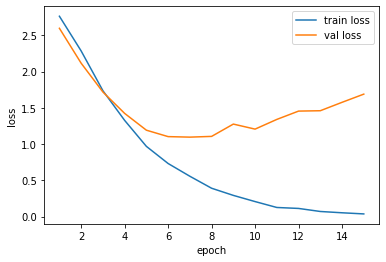

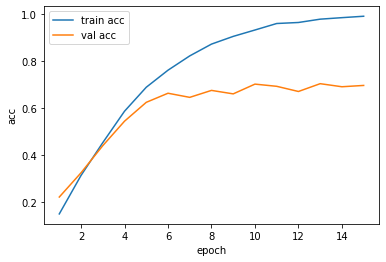

In [29]:
#plotting loss
plt.figure()
XX=list(range(1,epochs+1))
plt.plot(XX,train_loss_pe)
plt.plot(XX,val_loss_pe)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.legend(['train loss'])
plt.legend(['train loss','val loss'])


#plotting loss
plt.figure()
plt.plot(XX,train_acc_pe)
plt.plot(XX,val_acc_pe)
plt.xlabel('epoch')
plt.ylabel('acc')
#plt.legend(['train acc'])
plt.legend(['train acc','val acc'])

In [32]:
params_test={'batch_size': len(lbl_test),
          'shuffle': True,
          'num_workers': 6,'collate_fn':PaddingBatches()}


dataset_test=Customized_Dataset(sentences_test,lbl_test,MyVocab)
test_generator=DataLoader(dataset_test,**params_test)


for k,(mydata_test,mytarget_test,e1_start_test,e1_end_test,e2_start_test,e2_end_test) in enumerate(test_generator):
  #optimizer.zero_grad()
  n1=n1+1
  mydata_test=mydata_test.to(device)
  mytarget_test=mytarget_test.to(device)
  e1_start_test=e1_start_test.to(device)
  e1_end_test=e1_end_test.to(device)
  e2_start_test=e2_start_test.to(device)
  e2_end_test=e2_end_test.to(device)
  outputs_test=model(mydata_test,e1_start_test,e1_end_test,e2_start_test,e2_end_test)

  loss_test=criterian(outputs_test,mytarget_test)

  test_acc=accuracy(outputs_test,mytarget_test)

out_test=torch.argmax(outputs_test,1)
out_test=out_test.cpu()
out_test=out_test.numpy()

real_lbl=mytarget_test
real_lbl=real_lbl.cpu()
real_lbl=real_lbl.numpy()

test_recall=precision_score(real_lbl,out_test,average='weighted')
test_precision=f1_score(real_lbl,out_test,average='weighted')
test_f1=recall_score(real_lbl,out_test,average='weighted')

print('test accuracy is',test_acc)
print('test recall',test_recall)
print('test precision',test_precision)
print('test f1',test_f1)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


test accuracy is 0.6736196319018405
test recall 0.6787720582222371
test precision 0.6691831015725374
test f1 0.6736196319018405


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
import csv


#I saves confusion matrix array as a csv file and then processed it in excell
#result is in the report 
#it's because plot_confusion_

cm=confusion_matrix(real_lbl,out_test)


with open('myfile.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(cm)